In [1]:
import sys
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

In [2]:
n_features = 6  # Number of features
sequence_length = 20  # Length of each sequence

df = pd.read_csv('data.csv')
video_ids = df['video_id'].unique()

all_features = []  # Accumulate features
all_labels = []    # Accumulate labels

for video_id in video_ids:
    filtered_df = df[df['video_id'] == video_id]
    features = filtered_df[['crowd_density', 'crowd_count', 'loitering', 'low_concealment', 'med_concealment', 'high_concealment']]
    RBP = filtered_df['rbp'].iloc[0]
    features = features.to_numpy()
    n_seq = len(features) // sequence_length

    # Reshape the features into batches
    features = features[:sequence_length * n_seq].reshape(-1, sequence_length, n_features) # one video is one batch
    labels = [RBP] * n_seq

    # Extend the lists
    all_features.extend(features)
    all_labels.extend(labels)

# Convert to NumPy arrays
features = np.array(all_features)
labels = np.array(all_labels)

In [3]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)

In [5]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)  # Additional LSTM layer
        self.fc1 = nn.Linear(hidden_size, 64)  # First dense layer
        self.fc2 = nn.Linear(64, 32)  # Second dense layer
        self.fc3 = nn.Linear(32, 1)  # Single output neuron
        self.fc4 = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        out, (h_n, c_n) = self.lstm1(x)
        out, _ = self.lstm2(out, (h_n, c_n))  # Pass through the second LSTM layer
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [7]:
# Instantiate the model
input_size = n_features
hidden_size = 64
model = LSTMModel(input_size, hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training in progress: [==================================================] 100.0% [10/10 epochs]

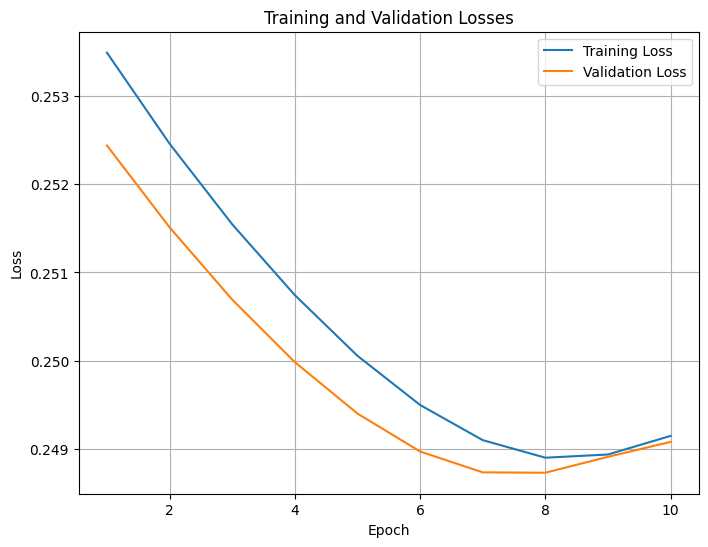

In [8]:
# Initialize empty lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor.unsqueeze(1))

    # Append losses to lists
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    # Training progress bar
    label = f"{epoch+1}/{n_epochs} epochs"
    progress = (epoch+1)/ n_epochs
    progress_bar_len = 50
    filled_len = int(progress_bar_len * progress)
    bar = '=' * filled_len + '-' * (progress_bar_len - filled_len)
    sys.stdout.write(f'\rTraining in progress: [{bar}] {progress * 100:.1f}% [{label}]')
    sys.stdout.flush()


# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)

    test_loss = criterion(test_outputs, y_test_tensor.unsqueeze(1))
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.2485


Optimal Threshold: 0.5612
Max F1 Score: nan


C:\Users\janrh\AppData\Local\Temp\ipykernel_21700\2445446893.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


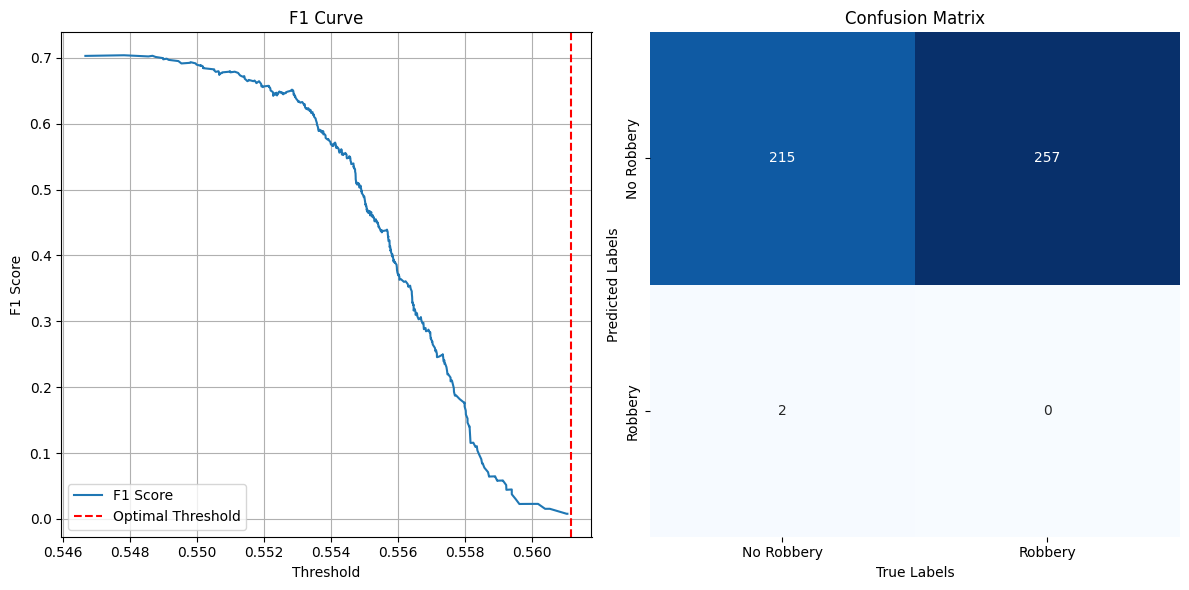

In [10]:
# Evaluation
precision, recall, thresholds = precision_recall_curve(y_test_tensor, test_outputs)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the optimal threshold that maximizes the F1 score
optimal_threshold = thresholds[f1_scores.argmax()]
max_f1_score = f1_scores.max()

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Max F1 Score: {max_f1_score:.4f}")

# Plot the F1 curve and the vertical line for the optimal threshold
plt.figure(figsize=(12, 6))

# F1 curve
plt.subplot(1, 2, 1)
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.grid(True)
plt.legend()

# Confusion matrix
plt.subplot(1, 2, 2)
test_outputs = (test_outputs >= optimal_threshold).float()
cm = confusion_matrix(y_test_tensor, test_outputs)
labels = ['No Robbery', 'Robbery']
cm_transposed = cm.T

sns.heatmap(cm_transposed, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [11]:
# Save the model
torch.save(model.state_dict(), f'model_{optimal_threshold}.pt')

In [12]:
for i in range(int(len(features)*0.15)):

    input_data = X_test[i]

    # Preprocess data
    input_data = scaler.fit_transform(input_data.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)[0]
    input_data = input_data.tolist()
    input_data = torch.tensor(input_data, dtype=torch.float32)

    # Ensure input shape matches
    if input_data.shape != (sequence_length, n_features):
        print('error: ', f'Input shape must be {(sequence_length, n_features)}. Yours has shape {input_data.shape}')

    # Make predictions
    with torch.no_grad():
        output = model(input_data.unsqueeze(0))  # Add batch dimension
        RBP = (output).squeeze().cpu().numpy()

    actualRBP = y_test[i]

    print(f"\nprediction: {RBP:.2f} | actual: {actualRBP}", end=" ")
    if ((RBP >= optimal_threshold) & (actualRBP == 1)) | ((RBP < optimal_threshold) & (actualRBP == 0)):
        print("| CORRECT", end="")


prediction: 0.55 | actual: 0 | CORRECT
prediction: 0.55 | actual: 1 
prediction: 0.56 | actual: 0 | CORRECT
prediction: 0.56 | actual: 1 
prediction: 0.56 | actual: 0 | CORRECT
prediction: 0.55 | actual: 1 
prediction: 0.56 | actual: 1 
prediction: 0.56 | actual: 1 
prediction: 0.55 | actual: 1 
prediction: 0.56 | actual: 0 | CORRECT
prediction: 0.55 | actual: 0 | CORRECT
prediction: 0.56 | actual: 1 
prediction: 0.56 | actual: 0 | CORRECT
prediction: 0.55 | actual: 1 
prediction: 0.55 | actual: 0 | CORRECT
prediction: 0.56 | actual: 1 
prediction: 0.56 | actual: 0 | CORRECT
prediction: 0.55 | actual: 1 
prediction: 0.56 | actual: 1 
prediction: 0.55 | actual: 1 
prediction: 0.56 | actual: 1 
prediction: 0.55 | actual: 0 | CORRECT
prediction: 0.55 | actual: 1 
prediction: 0.55 | actual: 1 
prediction: 0.55 | actual: 0 | CORRECT
prediction: 0.56 | actual: 0 | CORRECT
prediction: 0.55 | actual: 1 
prediction: 0.55 | actual: 0 | CORRECT
prediction: 0.55 | actual: 1 
prediction: 0.56 | ac

In [ ]:
# IF NEEDED

# # Plot the precision-recall curve
# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='Precision-Recall Curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plot the F1 curve
# plt.figure(figsize=(8, 6))
# plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
# plt.axvline(x=optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
# plt.xlabel('Threshold')
# plt.ylabel('F1 Score')
# plt.title('F1 Curve')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plot the Confusion matrix
# test_outputs = (test_outputs >= optimal_threshold).float()  # Convert probabilities to 0 or 1
# # test_outputs.squeeze(-1)

# cm = confusion_matrix(y_test_tensor, test_outputs)
# labels = ['No Robbery', 'Robbery']

# # Transpose the confusion matrix and swap axis labels
# cm_transposed = cm.T

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_transposed, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=labels, yticklabels=labels)  # Set labels for x and y axes
# plt.title('Confusion Matrix')
# plt.xlabel('True Labels')
# plt.ylabel('Predicted Labels')
# plt.show()
